In [1]:
%pip install torch
%pip install torchvision
%pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from torchsummary import summary
import torch.optim as optim
import os
import datetime

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Load CIFAR-10 dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### CNN Architecture


In [5]:
class CNN(nn.Module):
    def __init__(self, activation):
        super(CNN, self).__init__()
        self.activation = activation
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(4096, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.pool1(x)
        
        # Second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.pool2(x)
        
        # Third convolutional layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.pool3(x)
        
        # Flatten layer
        x = self.flatten(x)
        
        # Fully connected layers
        #first fc
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.activation(x)
        
        #second fc
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x

#### Function to train the model

In [6]:
def train_model(model, criterion, optimizer, train_loader, epochs,model_save_path):
    # Log the model summary
    summary(model, (3, 32, 32))

    start_time =  datetime.datetime.now()

    training_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            #reset the gradient
            optimizer.zero_grad()
            
            #Forward Propogation
            output = model(data)
            
            loss = criterion(output, target)
            #Backpropogate
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')
        training_losses.append((epoch + 1, avg_loss))
        
    end_time = datetime.datetime.now()
    
    training_time = end_time - start_time
    print(f"Training Time: {training_time} seconds")
    
    # Save the trained model parameters
    torch.save(model.state_dict(), model_save_path)
    print(f"Model parameters saved to: {model_save_path}")
    
    return training_losses

#### Function to evaluate model

In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy}')

In [8]:
import matplotlib.pyplot as plt

def plot_training_losses(training_losses, save_path=None):
    epochs, losses = zip(*training_losses)
    plt.plot(epochs, losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epoch')
    
    # Set x-axis ticks to integer values only
    plt.xticks(range(min(epochs), max(epochs)+1))
    
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to: {save_path}")
    plt.show()

#### Function to load the model

In [9]:
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set the model to evaluation mode
    return model

In [10]:
results_folder_path = 'results'
os.makedirs(results_folder_path, exist_ok=True)

In [11]:
results_second_architecture = "results/second architecture"
os.makedirs(results_second_architecture,exist_ok=True)

### ReLU Activation function

#### 1. ReLU without momentum

In [12]:
relu_wo_momentum = CNN(nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(relu_wo_momentum.parameters(),lr=0.001)

result_relu_wo_momentum_folder = "results/second architecture/relu_wo_momentum"
os.makedirs(result_relu_wo_momentum_folder,exist_ok=True)
relu_wo_momentum_save_path = os.path.join(result_relu_wo_momentum_folder, 'model.pth')

relu_wo_momentum_losses = train_model(relu_wo_momentum, criterion, optimizer, train_loader, epochs=20,model_save_path=relu_wo_momentum_save_path)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─ReLU: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1, 4096]                --


Plot saved to: results/second architecture/relu_wo_momentum/training_losses_plot


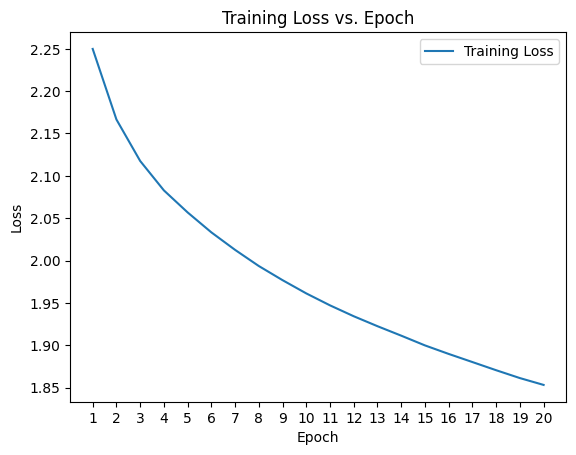

In [13]:
relu_wo_momentum_training_losses_save_path = os.path.join(result_relu_wo_momentum_folder, 'training_losses_plot')
plot_training_losses(relu_wo_momentum_losses,relu_wo_momentum_training_losses_save_path)

In [14]:
loaded_relu_wo_momentum_model = load_model(relu_wo_momentum, relu_wo_momentum_save_path)
loaded_relu_wo_momentum_model = loaded_relu_wo_momentum_model.to(device)
evaluate_model(loaded_relu_wo_momentum_model,test_loader)

Test Accuracy: 0.6373


#### 2. ReLU with momentum

ReLu with momentum - 0.5

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─ReLU: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1

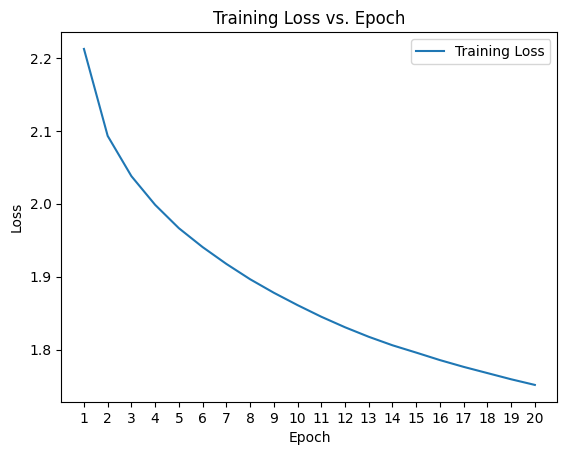

ReLu with momentum - 0.7

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─ReLU: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1

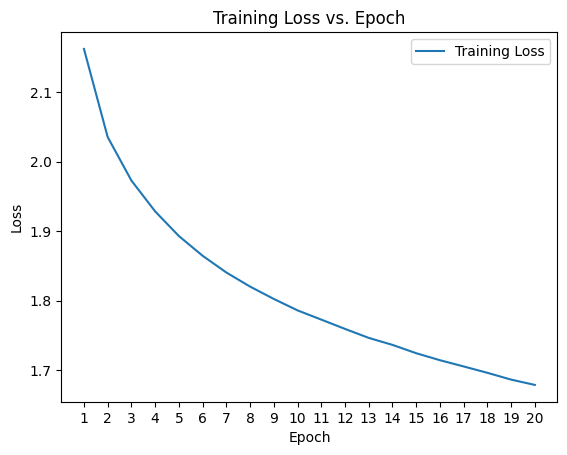

ReLu with momentum - 0.9

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─ReLU: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1

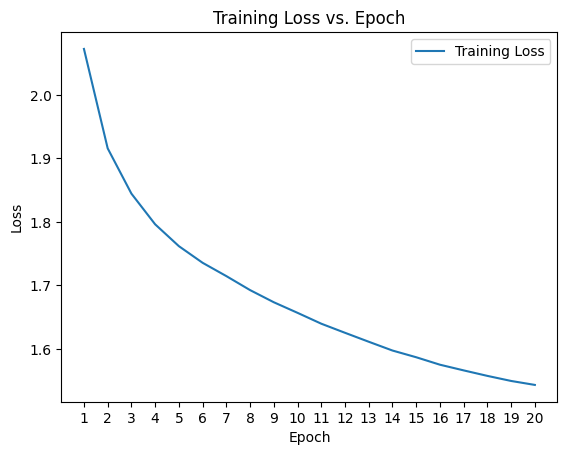

In [15]:
result_relu_w_momentum_folder = "results/second architecture/relu_w_momentum"
os.makedirs(result_relu_w_momentum_folder,exist_ok=True)

relu_mom_arr = [0.5, 0.7, 0.9] #momentum is a hyper parameter, we could try various values 

for mom in relu_mom_arr:
    print('ReLu with momentum - '+str(mom)+'\n')
    relu_w_momentum = CNN(nn.ReLU()).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(relu_w_momentum.parameters(),lr=0.001,momentum=mom)
    relu_w_momentum_save_path = os.path.join(result_relu_w_momentum_folder, 'model_mom=' + str(int(10*mom)) +'.pth')
    relu_w_momentum_training_loss = train_model(relu_w_momentum, criterion, optimizer, train_loader, epochs=20, model_save_path=relu_w_momentum_save_path)
    
    relu_w_momentum_training_loss_save_path = os.path.join(result_relu_w_momentum_folder, 'model_mom=' + str(int(10*mom)))
    plot_training_losses(relu_w_momentum_training_loss,relu_w_momentum_training_loss_save_path)

evaluate the trained models

In [16]:
for mom in relu_mom_arr:
    print('ReLu with momentum - '+str(mom))
    relu_w_momentum_save_path = os.path.join(result_relu_w_momentum_folder, 'model_mom=' + str(int(10*mom)) +'.pth')
    loaded_relu_w_momentum_model = load_model(relu_w_momentum, relu_w_momentum_save_path)
    loaded_relu_w_momentum_model = loaded_relu_w_momentum_model.to(device)
    evaluate_model(loaded_relu_w_momentum_model,test_loader)
    print('\n')

ReLu with momentum - 0.5
Test Accuracy: 0.7038


ReLu with momentum - 0.7
Test Accuracy: 0.7379


ReLu with momentum - 0.9
Test Accuracy: 0.7551




#### 3. ReLU with Adam

In [17]:
relu_w_adam = CNN(nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(relu_w_adam.parameters(),lr=0.001)

result_relu_w_adam_folder = "results/second architecture/relu_w_adam"
os.makedirs(result_relu_w_adam_folder, exist_ok=True)
relu_w_adam_save_path = os.path.join(result_relu_w_adam_folder, 'model.pth')

relu_w_adam_losses = train_model(relu_w_adam, criterion, optimizer, train_loader, epochs=20,model_save_path=relu_w_adam_save_path)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─ReLU: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1, 4096]                --


Plot saved to: results/second architecture/relu_w_adam/training_losses_plot


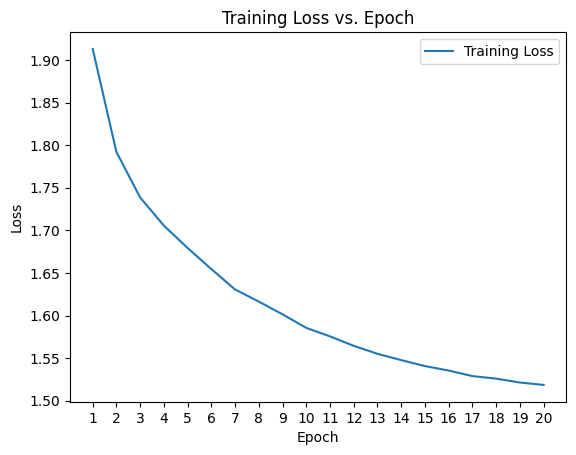

In [18]:
relu_w_adam_training_losses_save_path = os.path.join(result_relu_w_adam_folder, 'training_losses_plot')
plot_training_losses(relu_w_adam_losses,relu_w_adam_training_losses_save_path)

In [19]:
loaded_relu_w_adam_model = load_model(relu_w_adam, relu_w_adam_save_path)
loaded_relu_w_adam_model = loaded_relu_w_adam_model.to(device)
evaluate_model(loaded_relu_w_adam_model,test_loader)

Test Accuracy: 0.8021


### Tanh Activation function

#### 1. Tanh without momentum

In [20]:
tanh_wo_momentum = CNN(nn.Tanh()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(tanh_wo_momentum.parameters(),lr=0.001)

result_tanh_wo_momentum_folder = "results/second architecture/tanh_wo_momentum"
os.makedirs(result_tanh_wo_momentum_folder,exist_ok=True)
tanh_wo_momentum_save_path = os.path.join(result_tanh_wo_momentum_folder, 'model.pth')

tanh_wo_momentum_losses = train_model(tanh_wo_momentum, criterion, optimizer, train_loader, epochs=20,model_save_path=tanh_wo_momentum_save_path)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Tanh: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Tanh: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Tanh: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1, 4096]                --


Plot saved to: results/second architecture/relu_wo_momentum/training_losses_plot


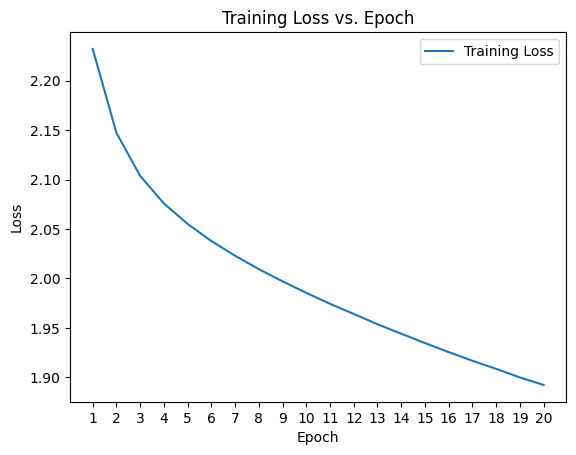

In [21]:
tanh_wo_momentum_training_losses_save_path = os.path.join(result_tanh_wo_momentum_folder, 'training_losses_plot')
plot_training_losses(tanh_wo_momentum_losses,tanh_wo_momentum_training_losses_save_path)

In [22]:
loaded_tanh_wo_momentum_model = load_model(tanh_wo_momentum, tanh_wo_momentum_save_path)
loaded_tanh_wo_momentum_model = loaded_tanh_wo_momentum_model.to(device)
evaluate_model(loaded_tanh_wo_momentum_model,test_loader)

Test Accuracy: 0.5861


#### 2. Tanh with momentum

tanh with momentum - 0.5

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Tanh: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Tanh: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Tanh: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1

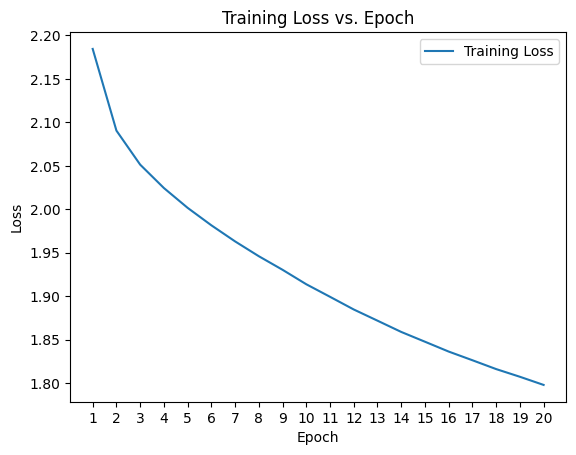

tanh with momentum - 0.7

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Tanh: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Tanh: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Tanh: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1

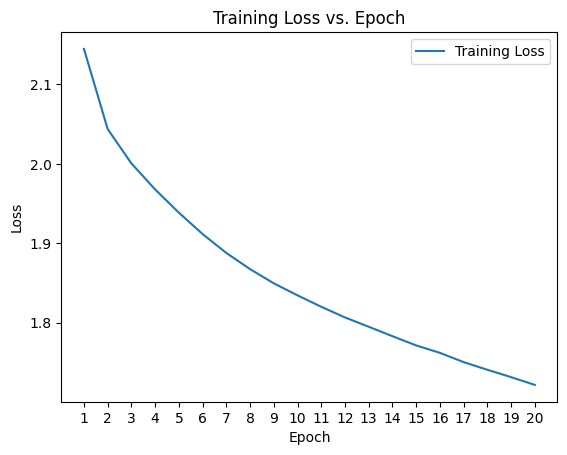

tanh with momentum - 0.9

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Tanh: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Tanh: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Tanh: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1

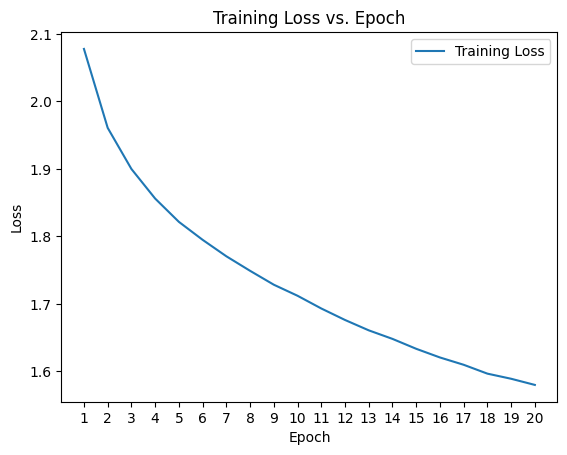

In [23]:
result_tanh_w_momentum_folder = "results/second architecture/tanh_w_momentum"
os.makedirs(result_tanh_w_momentum_folder,exist_ok=True)

tanh_mom_arr = [0.5, 0.7, 0.9] #momentum is a hyper parameter, we could try various values 

for mom in tanh_mom_arr:
    print('tanh with momentum - '+str(mom)+'\n')
    tanh_w_momentum = CNN(nn.Tanh()).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(tanh_w_momentum.parameters(),lr=0.001,momentum=mom)
    tanh_w_momentum_save_path = os.path.join(result_tanh_w_momentum_folder, 'model_mom=' + str(int(10*mom)) +'.pth')
    tanh_w_momentum_training_loss = train_model(tanh_w_momentum, criterion, optimizer, train_loader, epochs=20, model_save_path=tanh_w_momentum_save_path)
    
    tanh_w_momentum_training_loss_save_path = os.path.join(result_tanh_w_momentum_folder, 'model_mom=' + str(int(10*mom)))
    plot_training_losses(tanh_w_momentum_training_loss,tanh_w_momentum_training_loss_save_path)

evaluate the trained models

In [24]:
for mom in tanh_mom_arr:
    print('tanh with momentum - '+str(mom))
    tanh_w_momentum_save_path = os.path.join(result_tanh_w_momentum_folder, 'model_mom=' + str(int(10*mom)) +'.pth')
    loaded_tanh_w_momentum_model = load_model(tanh_w_momentum, tanh_w_momentum_save_path)
    loaded_tanh_w_momentum_model = loaded_tanh_w_momentum_model.to(device)
    evaluate_model(loaded_tanh_w_momentum_model,test_loader)
    print('\n')

tanh with momentum - 0.5
Test Accuracy: 0.6452


tanh with momentum - 0.7
Test Accuracy: 0.6908


tanh with momentum - 0.9
Test Accuracy: 0.7084




#### 3. Tanh with Adam

In [25]:
tanh_w_adam = CNN(nn.Tanh()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tanh_w_adam.parameters(),lr=0.001)

result_tanh_w_adam_folder = "results/second architecture/tanh_w_adam"
os.makedirs(result_tanh_w_adam_folder, exist_ok=True)
tanh_w_adam_save_path = os.path.join(result_tanh_w_adam_folder, 'model.pth')

tanh_w_adam_losses = train_model(tanh_w_adam, criterion, optimizer, train_loader, epochs=20,model_save_path=tanh_w_adam_save_path)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Tanh: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Tanh: 1-7                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Tanh: 1-11                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1, 4096]                --


Plot saved to: results/second architecture/tanh_w_adam/training_losses_plot


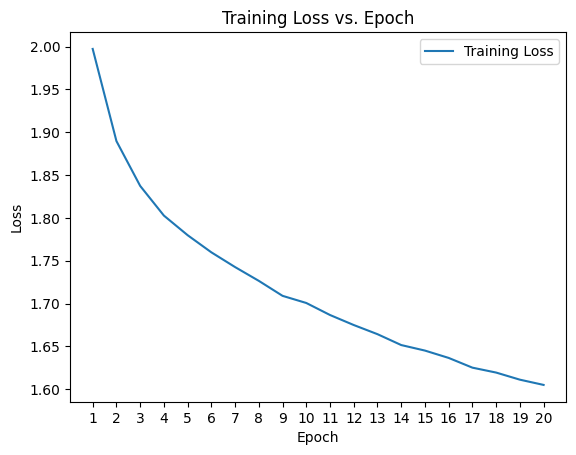

In [26]:
tanh_w_adam_training_losses_save_path = os.path.join(result_tanh_w_adam_folder, 'training_losses_plot')
plot_training_losses(tanh_w_adam_losses,tanh_w_adam_training_losses_save_path)

In [27]:
loaded_tanh_w_adam_model = load_model(tanh_w_adam, tanh_w_adam_save_path)
loaded_tanh_w_adam_model = loaded_tanh_w_adam_model.to(device)
evaluate_model(loaded_tanh_w_adam_model,test_loader)

Test Accuracy: 0.7337


### Sigmoid Activation function

#### 1. Sigmoid without momentum

In [28]:
sigmoid_wo_momentum = CNN(nn.Sigmoid()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(sigmoid_wo_momentum.parameters(),lr=0.001)

result_sigmoid_wo_momentum_folder = "results/second architecture/sigmoid_wo_momentum"
os.makedirs(result_sigmoid_wo_momentum_folder,exist_ok=True)
sigmoid_wo_momentum_save_path = os.path.join(result_sigmoid_wo_momentum_folder, 'model.pth')

sigmoid_wo_momentum_losses = train_model(sigmoid_wo_momentum, criterion, optimizer, train_loader, epochs=20,model_save_path=sigmoid_wo_momentum_save_path)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sigmoid: 1-3                           [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Sigmoid: 1-7                           [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Sigmoid: 1-11                          [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1, 4096]                --


Plot saved to: results/second architecture/relu_wo_momentum/training_losses_plot


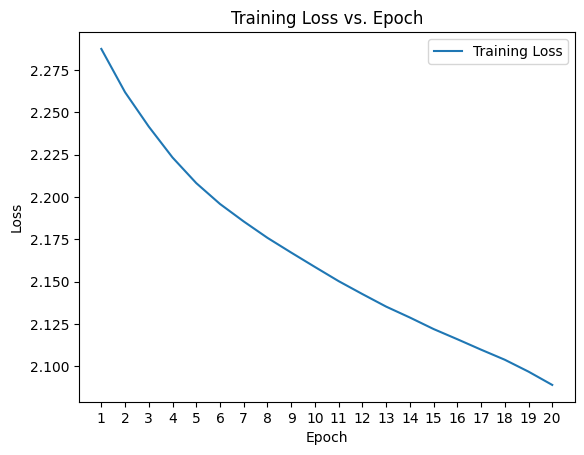

In [29]:
sigmoid_wo_momentum_training_losses_save_path = os.path.join(result_sigmoid_wo_momentum_folder, 'training_losses_plot')
plot_training_losses(sigmoid_wo_momentum_losses,sigmoid_wo_momentum_training_losses_save_path)

In [30]:
loaded_sigmoid_wo_momentum_model = load_model(sigmoid_wo_momentum, sigmoid_wo_momentum_save_path)
loaded_sigmoid_wo_momentum_model = loaded_sigmoid_wo_momentum_model.to(device)
evaluate_model(loaded_sigmoid_wo_momentum_model,test_loader)

Test Accuracy: 0.4379


#### 2. Sigmoid with momentum

sigmoid with momentum - 0.5

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sigmoid: 1-3                           [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Sigmoid: 1-7                           [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Sigmoid: 1-11                          [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          

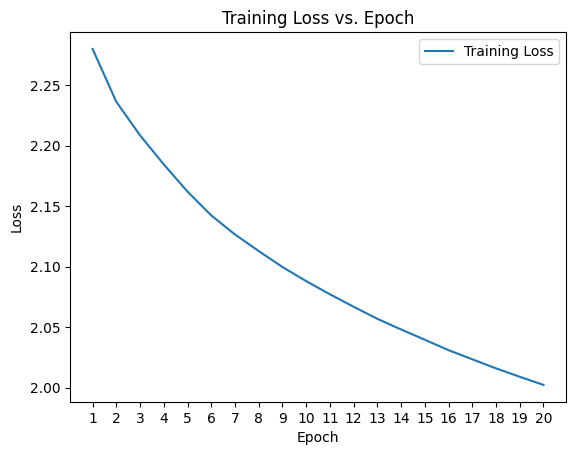

sigmoid with momentum - 0.7

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sigmoid: 1-3                           [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Sigmoid: 1-7                           [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Sigmoid: 1-11                          [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          

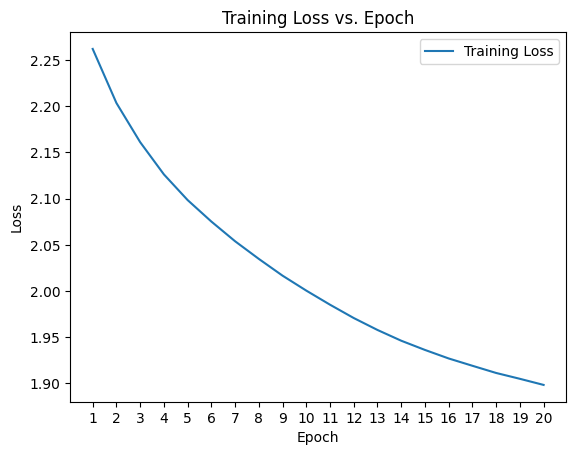

sigmoid with momentum - 0.9

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sigmoid: 1-3                           [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Sigmoid: 1-7                           [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Sigmoid: 1-11                          [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          

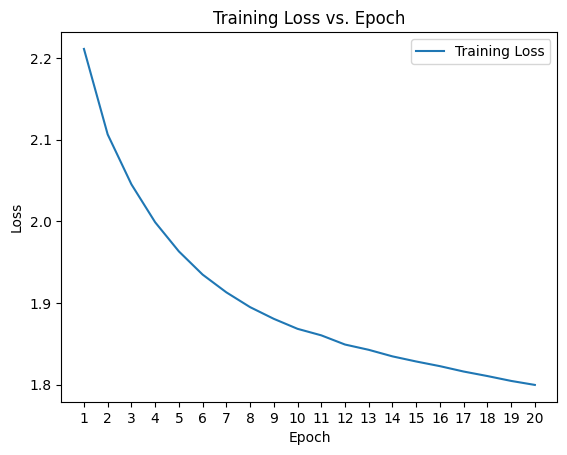

In [31]:
result_sigmoid_w_momentum_folder = "results/second architecture/sigmoid_w_momentum"
os.makedirs(result_sigmoid_w_momentum_folder,exist_ok=True)

sigmoid_mom_arr = [0.5, 0.7, 0.9] #momentum is a hyper parameter, we could try various values 

for mom in sigmoid_mom_arr:
    print('sigmoid with momentum - '+str(mom)+'\n')
    sigmoid_w_momentum = CNN(nn.Sigmoid()).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(sigmoid_w_momentum.parameters(),lr=0.001,momentum=mom)
    sigmoid_w_momentum_save_path = os.path.join(result_sigmoid_w_momentum_folder, 'model_mom=' + str(int(10*mom)) +'.pth')
    sigmoid_w_momentum_training_loss = train_model(sigmoid_w_momentum, criterion, optimizer, train_loader, epochs=20, model_save_path=sigmoid_w_momentum_save_path)
    
    sigmoid_w_momentum_training_loss_save_path = os.path.join(result_sigmoid_w_momentum_folder, 'model_mom=' + str(int(10*mom)))
    plot_training_losses(sigmoid_w_momentum_training_loss,sigmoid_w_momentum_training_loss_save_path)

evaluate the trained models

In [32]:
for mom in sigmoid_mom_arr:
    print('sigmoid with momentum - '+str(mom))
    sigmoid_w_momentum_save_path = os.path.join(result_sigmoid_w_momentum_folder, 'model_mom=' + str(int(10*mom)) +'.pth')
    loaded_sigmoid_w_momentum_model = load_model(sigmoid_w_momentum, sigmoid_w_momentum_save_path)
    loaded_sigmoid_w_momentum_model = loaded_sigmoid_w_momentum_model.to(device)
    evaluate_model(loaded_sigmoid_w_momentum_model,test_loader)
    print('\n')

sigmoid with momentum - 0.5
Test Accuracy: 0.501


sigmoid with momentum - 0.7
Test Accuracy: 0.5883


sigmoid with momentum - 0.9
Test Accuracy: 0.6204




#### 3. Tanh with Adam

In [33]:
sigmoid_w_adam = CNN(nn.Sigmoid()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sigmoid_w_adam.parameters(),lr=0.001)

result_sigmoid_w_adam_folder = "results/second architecture/sigmoid_w_adam"
os.makedirs(result_sigmoid_w_adam_folder, exist_ok=True)
sigmoid_w_adam_save_path = os.path.join(result_sigmoid_w_adam_folder, 'model.pth')

sigmoid_w_adam_losses = train_model(sigmoid_w_adam, criterion, optimizer, train_loader, epochs=20,model_save_path=sigmoid_w_adam_save_path)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─Sigmoid: 1-3                           [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-6                       [-1, 128, 16, 16]         256
├─Sigmoid: 1-7                           [-1, 128, 16, 16]         --
├─MaxPool2d: 1-8                         [-1, 128, 8, 8]           --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─Sigmoid: 1-11                          [-1, 256, 8, 8]           --
├─MaxPool2d: 1-12                        [-1, 256, 4, 4]           --
├─Flatten: 1-13                          [-1, 4096]                --


Plot saved to: results/second architecture/sigmoid_w_adam/training_losses_plot


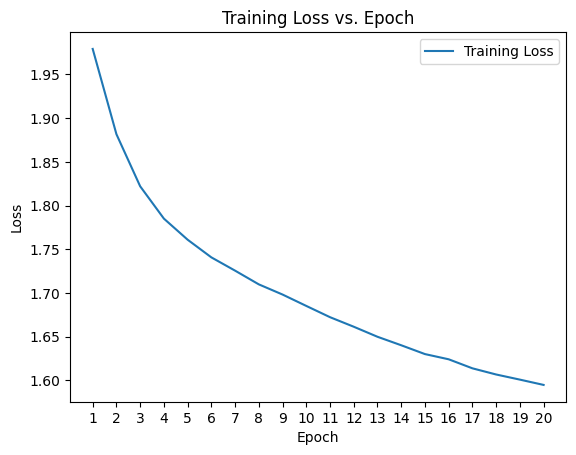

In [34]:
sigmoid_w_adam_training_losses_save_path = os.path.join(result_sigmoid_w_adam_folder, 'training_losses_plot')
plot_training_losses(sigmoid_w_adam_losses,sigmoid_w_adam_training_losses_save_path)

In [35]:
loaded_sigmoid_w_adam_model = load_model(sigmoid_w_adam, sigmoid_w_adam_save_path)
loaded_sigmoid_w_adam_model = loaded_sigmoid_w_adam_model.to(device)
evaluate_model(loaded_sigmoid_w_adam_model,test_loader)

Test Accuracy: 0.6396
